In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 10]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

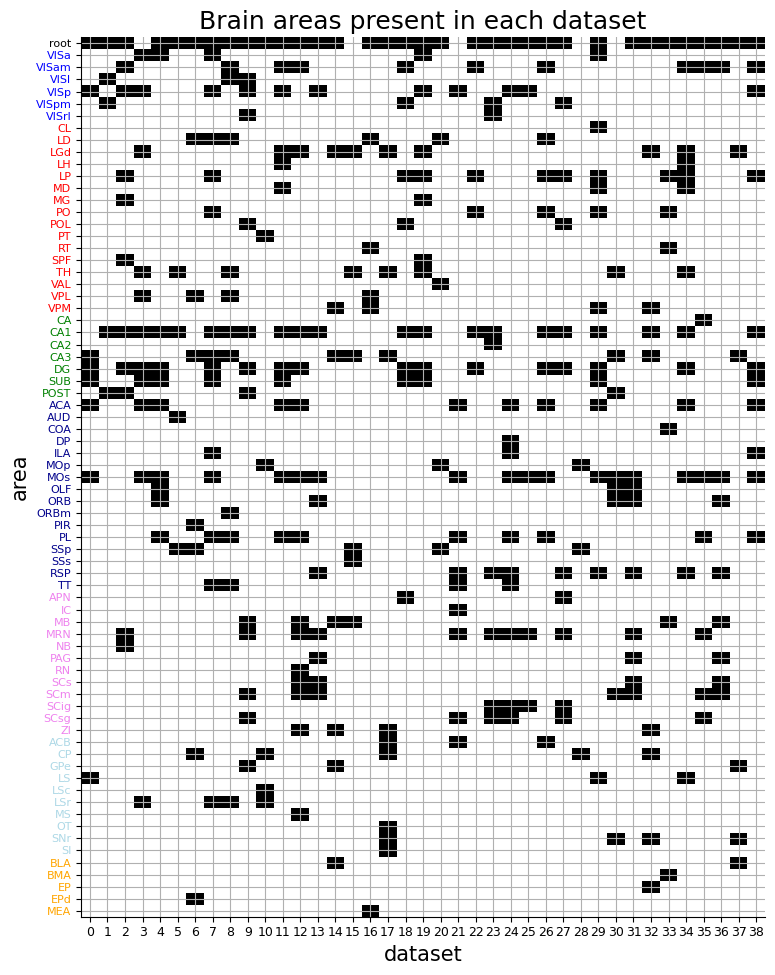

In [6]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [7]:
# @title Selecting a Session
dat = alldat[31]

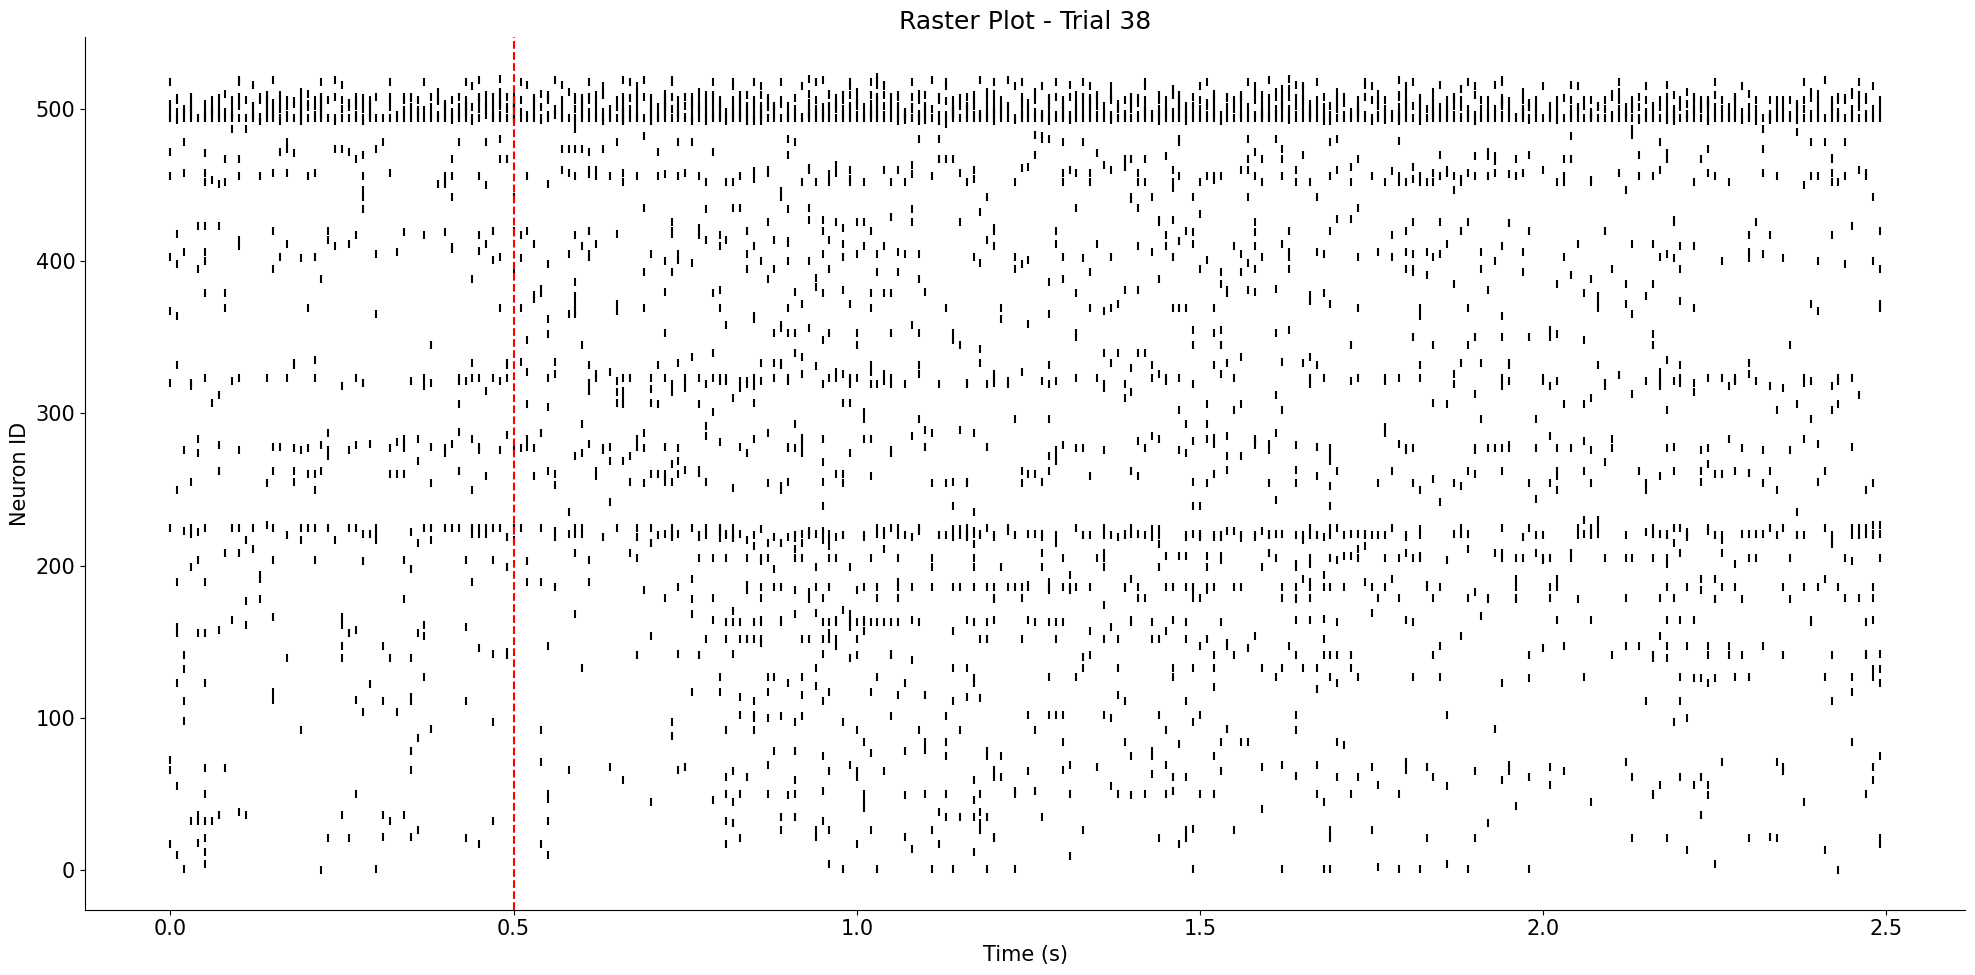

In [8]:
# @title Raster Plot
def plot_raster(spike_times, trial, stim_onset, neuron_to_exclude=None, color='k'):
    """
    Generates a raster plot for the given spike times.

    Parameters:
    spike_times : 3D array
        A 3D array where the first dimension represents neurons, the second represents trials,
        and the third represents time.
    trial : int
        The trial number to plot.
    stim_onset : float
        The time (in seconds) at which the stimulus onset occurred.
    neuron_to_exclude : int, optional
        The ID of a neuron to exclude from the plot.
    color : str, optional
        The color of the spikes. Default is 'k' (black).
    """
    spike_times_trial = spike_times[:, trial, :]
    time_bin_width = 0.01  # Width of time bin in seconds
    neurons = range(spike_times_trial.shape[0])
    if neuron_to_exclude is not None:
        neurons = [n for n in neurons if n != neuron_to_exclude]
    for neuron_id in neurons:
        spikes = spike_times_trial[neuron_id]
        spike_times = np.where(spikes)[0] * time_bin_width  # Convert time bins to seconds
        plt.scatter(spike_times, [neuron_id]*len(spike_times), marker='|', color=color)

    plt.axvline(x=stim_onset, color='r', linestyle='--')  # Draw vertical line at stimulus onset
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron ID')
    plt.title('Raster Plot - Trial {}'.format(trial))
    plt.show()

spike_times = dat['spks']
# For trial number 38, with stimulus onset at 0.5 seconds
plot_raster(spike_times, trial=38, stim_onset=0.5)

In [9]:
# @title Available Brain Areas
a = np.unique(dat['brain_area'])
print(f'Available brain areas in this session: {a}')

Available brain areas in this session: ['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']


In [10]:
#15 latent components
ncomp = 15
# every "bin" is 10ms, so the trial length is 2500ms
NT = 250

In [11]:
# @title RNN predicting one Area's Activity (Secondary Motor Cortex) based on other Areas
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [12]:
regions_data = dat['spks'][dat['brain_area'] != 'MOs']
MOs_data = dat['spks'][dat['brain_area'] == 'MOs']

In [13]:
# @title Train and Test Split
percent_train = 0.8
num_trial = MOs_data.shape[1]
idx = np.random.choice(np.arange(num_trial), num_trial, replace=False)
idx_train = idx[: int(percent_train * num_trial)]
idx_test = idx[int(percent_train * num_trial): ]
x_train = regions_data[:, idx_train, :]
y_train = MOs_data[:, idx_train, :]

x_test = regions_data[:, idx_test, :]
y_test = MOs_data[:, idx_test, :]

x_train = np.swapaxes(x_train, 0, 2)
y_train = np.swapaxes(y_train, 0, 2)
x_test = np.swapaxes(x_test, 0, 2)
y_test = np.swapaxes(y_test, 0, 2)

print(f'Shape of data is Time * Trials * Neurons')
print(f'Shape of train data; input:{x_train.shape}, output:{y_train.shape}')
print(f'Shape of test data; input:{x_test.shape}, output:{y_test.shape}')

Shape of data is Time * Trials * Neurons
Shape of train data; input:(250, 208, 453), output:(250, 208, 69)
Shape of test data; input:(250, 52, 453), output:(250, 52, 69)


In [14]:
input_population = torch.from_numpy(x_train).to(device).float()
output_population = torch.from_numpy(y_train).to(device).float()
NN1 = input_population.shape[-1]
NN2 = output_population.shape[-1]
print(NN1, NN2)

453 69


In [15]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = input_population.mean()

In [16]:
# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.0001)

In [17]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(input_population)

  # our log-likelihood cost
  cost = Poisson_loss(z, output_population).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.1782
iteration 100, cost 0.0980
iteration 200, cost 0.0926
iteration 300, cost 0.0903
iteration 400, cost 0.0887
iteration 500, cost 0.0875
iteration 600, cost 0.0870
iteration 700, cost 0.0867
iteration 800, cost 0.0862
iteration 900, cost 0.0859


In [18]:
# Test
input_population_test = torch.from_numpy(x_test).to(device).float()
output_population_test = torch.from_numpy(y_test).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

torch.Size([250, 52, 69]) torch.Size([250, 52, 15])


Cost on training set: 0.08564062416553497


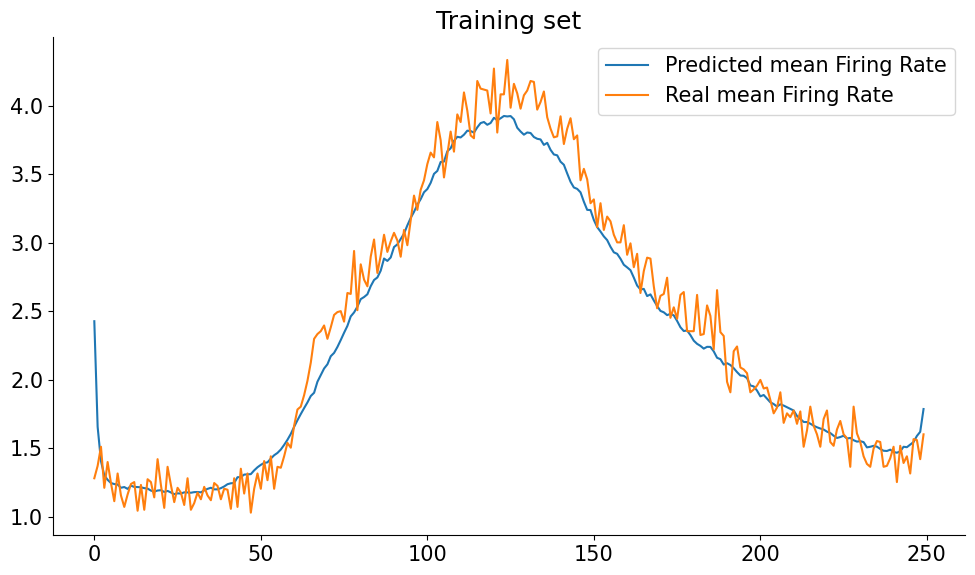

In [19]:
# Training set; avg across  all trials and neurons
dt = dat['bin_size']
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train.mean(axis=(1, 2))
cost_train = Poisson_loss(z, output_population).mean()
print(f'Cost on training set: {cost_train}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.title('Training set')
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.show()

Cost on test set: 0.09230775386095047


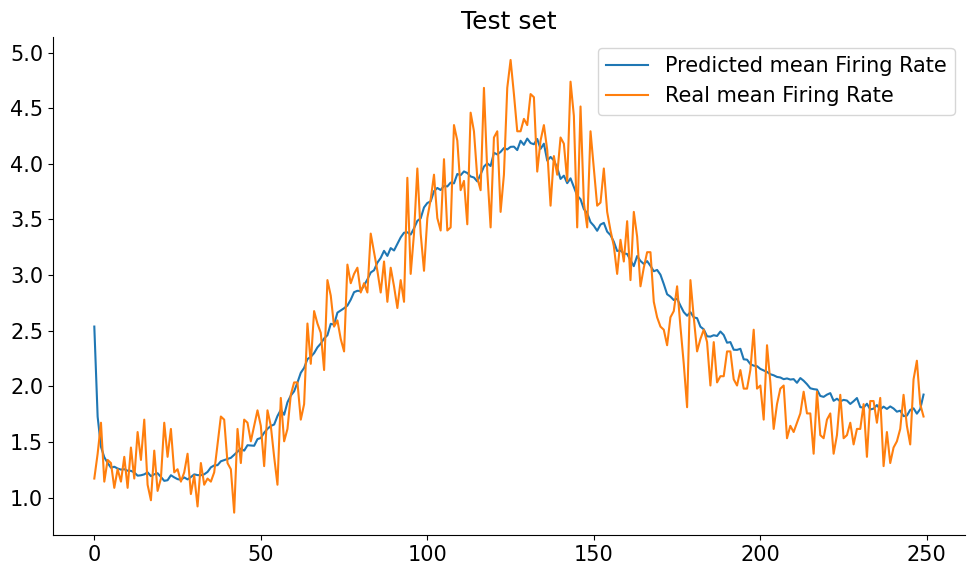

In [20]:
# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test.mean(axis=(1, 2))
cost_test = Poisson_loss(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.title('Test set')
plt.show()

In [21]:
# @title LSTM predicting one Area's Activity (Secondary Motor Cortex) based on other Areas
#15 latent components
ncomp = 15
# every "bin" is 10ms, so the trial length is 2500ms
NT = 250
# LSTM
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the LSTM!
    self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi)
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y, _ = self.rnn(x)

    if self.rnn.bidirectional:
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    z = F.softplus(self.fc(q), 10)

    return z, q

iteration 0, cost 0.1473
iteration 100, cost 0.0956
iteration 200, cost 0.0899
iteration 300, cost 0.0872
iteration 400, cost 0.0856
iteration 500, cost 0.0844
iteration 600, cost 0.0839
iteration 700, cost 0.0836
iteration 800, cost 0.0832
iteration 900, cost 0.0830
torch.Size([250, 52, 69]) torch.Size([250, 52, 15])
Cost on training set: 0.08289267867803574


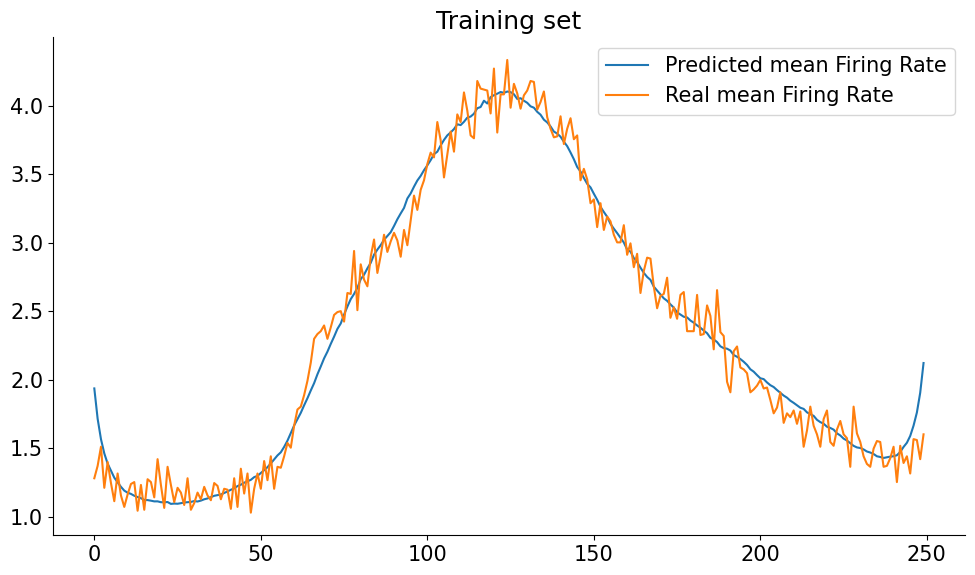

Cost on test set: 0.09125445783138275


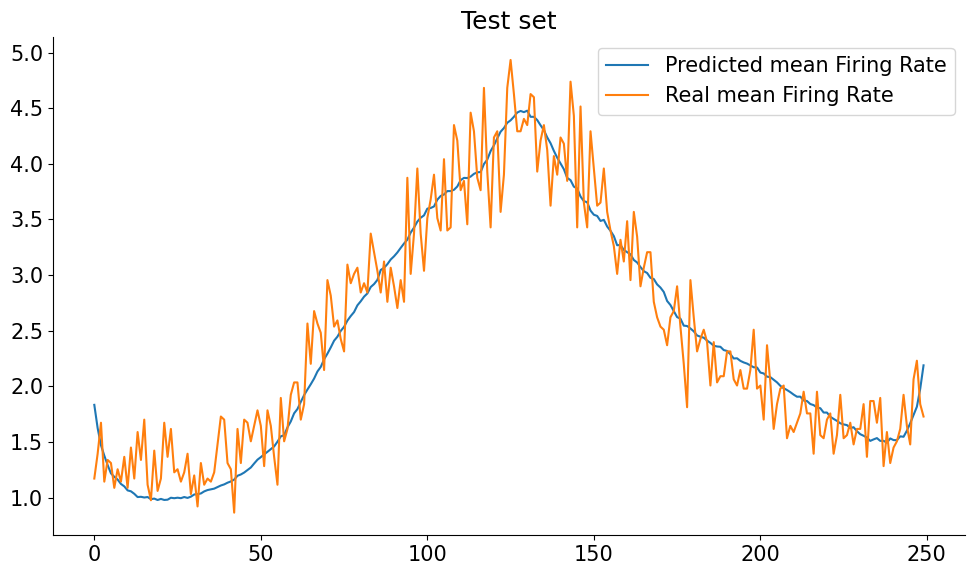

In [22]:
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

net.fc.bias.data[:] = input_population.mean()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.0001)


niter = 1000
for k in range(niter):
  z, y = net(input_population)
  cost = Poisson_loss(z, output_population).mean()
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')


# Test
input_population_test = torch.from_numpy(x_test).to(device).float()
output_population_test = torch.from_numpy(y_test).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

# Training set; avg across  all trials and neurons
dt = dat['bin_size']
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train.mean(axis=(1, 2))
cost_train = Poisson_loss(z, output_population).mean()
print(f'Cost on training set: {cost_train}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.title('Training set')
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.show()

# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test.mean(axis=(1, 2))
cost_test = Poisson_loss(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.title('Test set')
plt.show()

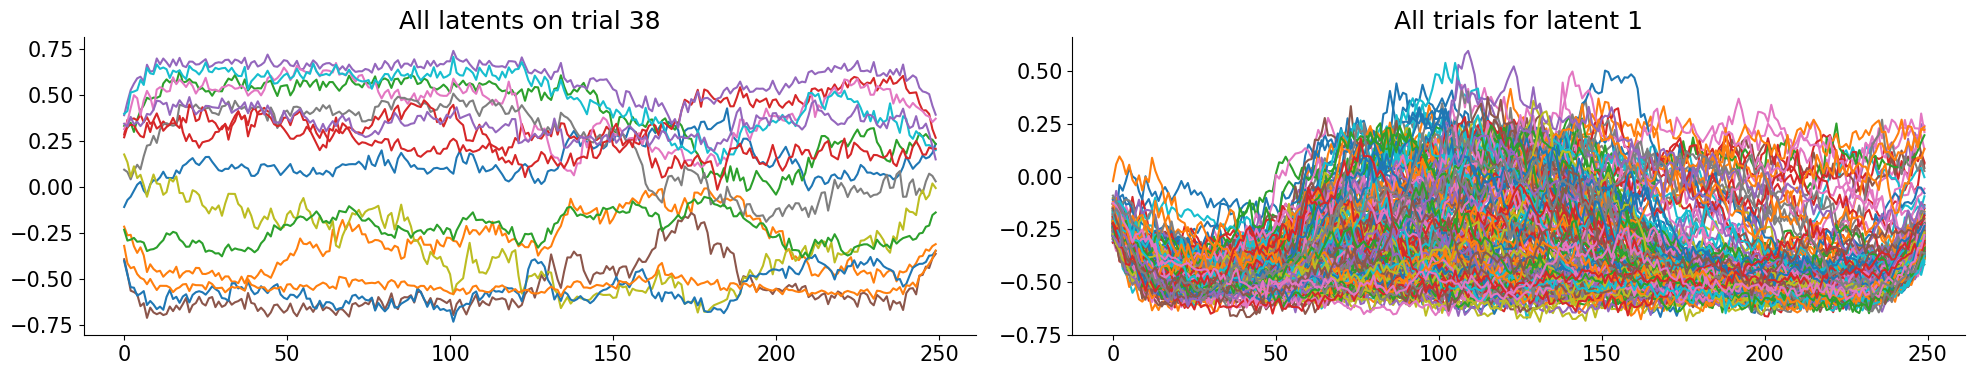

In [23]:
ycpu = y.detach().cpu().numpy()

trial = 38
plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, trial, :]);
plt.title(f'All latents on trial {trial}')

latent = 1
plt.subplot(122)
plt.plot(ycpu[:, :, latent]);
plt.title(f'All trials for latent {latent}')
plt.show()

Shape of train data; input:(250, 208, 34), output:(250, 208, 34)
Shape of test data; input:(250, 52, 34), output:(250, 52, 34)
34 34
iteration 0, cost 0.1643
iteration 100, cost 0.1085
iteration 200, cost 0.1034
iteration 300, cost 0.1018
iteration 400, cost 0.1011
iteration 500, cost 0.1005
iteration 600, cost 0.0998
iteration 700, cost 0.0990
iteration 800, cost 0.0985
iteration 900, cost 0.0982
torch.Size([250, 52, 34]) torch.Size([250, 52, 15])
Cost on training set: 0.09799297153949738


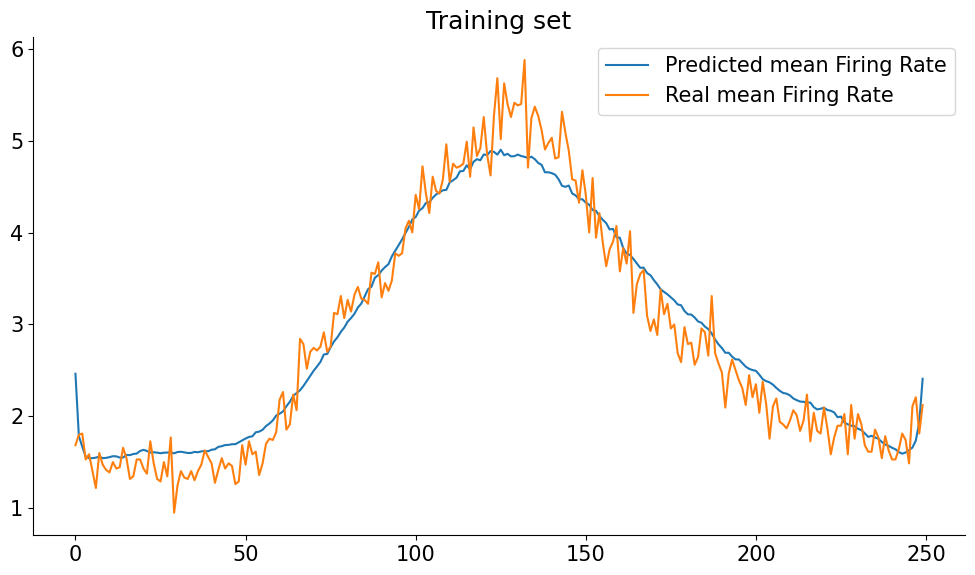

Cost on test set: 0.10301470756530762


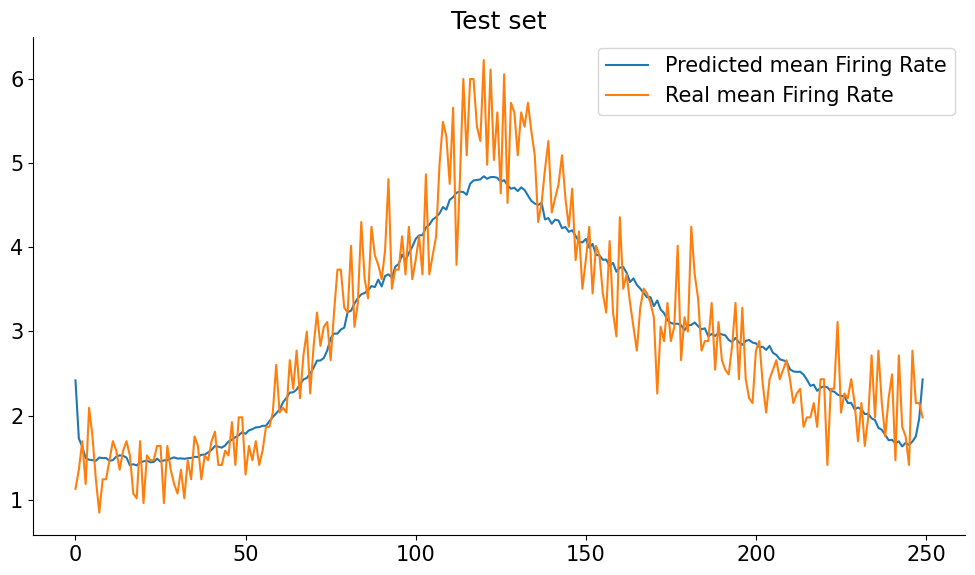

In [24]:
# @title RNN Predicting one Area's Activity (Secondary Motor Cortex)
MOs_data = dat['spks'][dat['brain_area'] == 'MOs']
MOs1 = MOs_data[0:34]
MOs2 = MOs_data[34:68]
# Generate train and test data
percent_train = 0.8
num_trial = MOs2.shape[1]
idx = np.random.choice(np.arange(num_trial), num_trial, replace=False)
idx_train = idx[: int(percent_train * num_trial)]
idx_test = idx[int(percent_train * num_trial): ]
x_train = MOs1[:, idx_train, :]
y_train = MOs2[:, idx_train, :]

x_test = MOs1[:, idx_test, :]
y_test = MOs2[:, idx_test, :]

x_train = np.swapaxes(x_train, 0, 2)
y_train = np.swapaxes(y_train, 0, 2)
x_test = np.swapaxes(x_test, 0, 2)
y_test = np.swapaxes(y_test, 0, 2)

print(f'Shape of train data; input:{x_train.shape}, output:{y_train.shape}')
print(f'Shape of test data; input:{x_test.shape}, output:{y_test.shape}')
input_population = torch.from_numpy(x_train).to(device).float()
output_population = torch.from_numpy(y_train).to(device).float()
NN1 = input_population.shape[-1]
NN2 = output_population.shape[-1]
print(NN1, NN2)

class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:

      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    z = F.softplus(self.fc(q), 10)

    return z, q

net = Net(ncomp, NN1, NN2, bidi = True).to(device)

net.fc.bias.data[:] = input_population.mean()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

niter = 1000
for k in range(niter):
  z, y = net(input_population)
  cost = Poisson_loss(z, output_population).mean()
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')


# Test
input_population_test = torch.from_numpy(x_test).to(device).float()
output_population_test = torch.from_numpy(y_test).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

# Training set; avg across  all trials and neurons
dt = dat['bin_size']
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train.mean(axis=(1, 2))
cost_train = Poisson_loss(z, output_population).mean()
print(f'Cost on training set: {cost_train}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.title('Training set')
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.show()

# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test.mean(axis=(1, 2))
cost_test = Poisson_loss(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.title('Test set')
plt.show()

iteration 0, cost 0.1466
iteration 100, cost 0.1081
iteration 200, cost 0.1005
iteration 300, cost 0.0983
iteration 400, cost 0.0974
torch.Size([250, 52, 34]) torch.Size([250, 52, 15])
Cost on training set: 0.09668596088886261


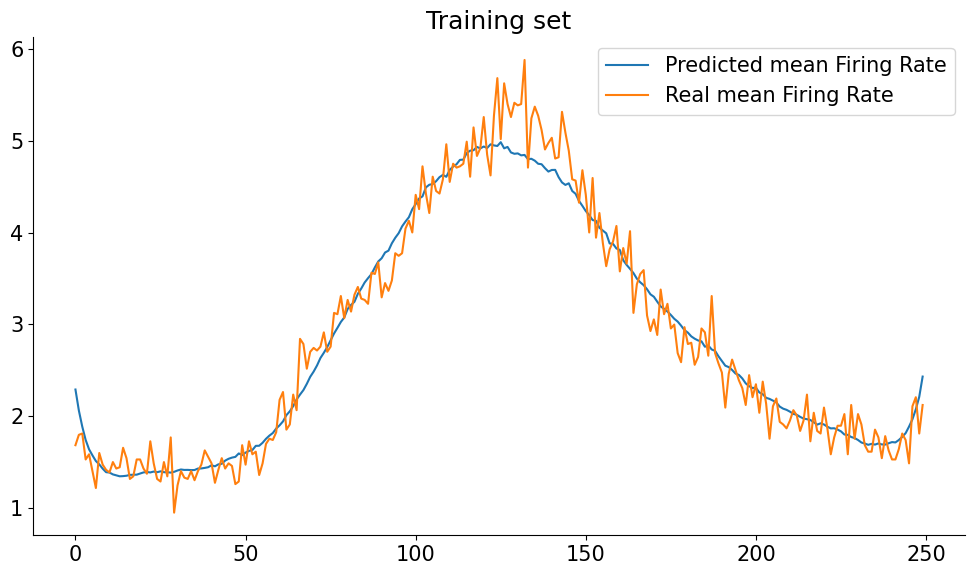

Cost on test set: 0.10204724967479706


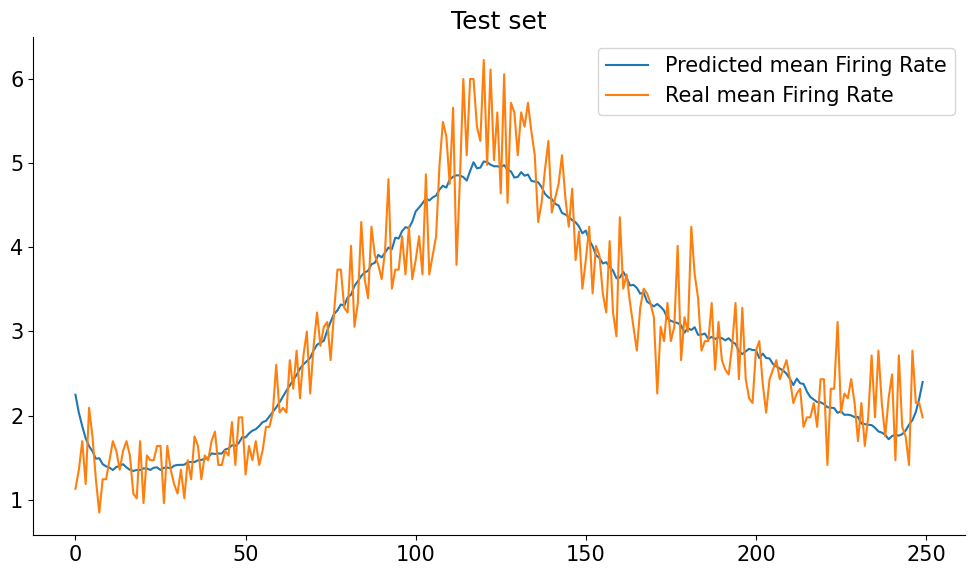

In [25]:
# LSTM Predicting one Area's Activity (Secondary Motor Cortex)
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the LSTM!
    self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi)
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y, _ = self.rnn(x)

    if self.rnn.bidirectional:
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    z = F.softplus(self.fc(q), 10)

    return z, q

net = Net(ncomp, NN1, NN2, bidi = True).to(device)

net.fc.bias.data[:] = input_population.mean()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

niter = 500
for k in range(niter):
  z, y = net(input_population)
  cost = Poisson_loss(z, output_population).mean()
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')


# Test
input_population_test = torch.from_numpy(x_test).to(device).float()
output_population_test = torch.from_numpy(y_test).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

# Training set; avg across  all trials and neurons
dt = dat['bin_size']
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train.mean(axis=(1, 2))
cost_train = Poisson_loss(z, output_population).mean()
print(f'Cost on training set: {cost_train}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.title('Training set')
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.show()

# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test.mean(axis=(1, 2))
cost_test = Poisson_loss(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.legend(['Predicted mean Firing Rate', 'Real mean Firing Rate'])
plt.title('Test set')
plt.show()